
An at the money option is about 9 bucks for 100 shares, with an ivol of about 8.5

Also, 1 month out ATM options are 2% price

For example on July 27th,



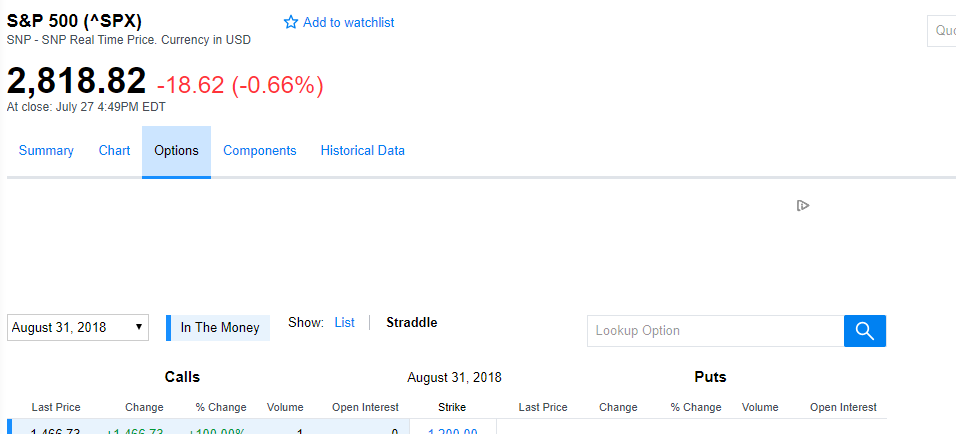

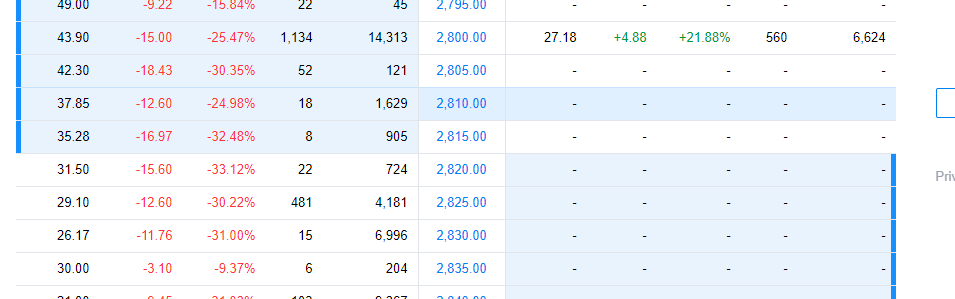

Implying about  1.125% premium


In [8]:
# test the idea of trading against an option
# S&P 500 (^GSPC)

from pylab import *

import pandas as pd
import tqdm
# import tensorflow as tf
from collections import OrderedDict, defaultdict
import random


%alias_magic -p nbagg nbagg matplotlib

data = pd.read_csv( '../data/^GSPC.csv')

data.index =  pd.to_datetime( data.Date, format='%Y-%m-%d')
data['close_rtn'] = data.Close.pct_change()
data['open_rtn'] = data.Open.pct_change()
data['rtn'] = data.open_rtn
data['vol_30'] = data.rtn.rolling(window=30).std()
data['vol_60'] = data.rtn.rolling(window=60).std()

Created `%nbagg` as an alias for `%matplotlib nbagg`.


In [ ]:
# plot the vol of the spx returns
##############################################
%nbagg
plot( data.vol_30, '-b')
plot( data.vol_60, '-k')

gca().twinx().plot(data.rtn.rolling(window=30).mean(), '-r')

print( 'volatility quantiles', data.rtn.rolling(window=30).std().quantile(linspace(0,1,5)), data.rtn.rolling(window=30).std().mean(), )

figure()
data.rtn.rolling(window=30).std().hist(bins=100)
figure()
data.rtn.hist(bins=100)

print( 'return quantiles', data.rtn.quantile(linspace(0,1,5)), data.rtn.mean(), )

In [ ]:
data


In [ ]:
%pdb


In [ ]:
data.iloc[10]


In [12]:
option_cost


30000.0

In [112]:
# new simulation .... piecewise

capacity = 1e2 # capacity in num shares
option_rate = 0.015 # 
horizon = 30  # horizon / holding period
# daily capacity 
daily_capacity = capacity / 2
avg_vol = 0.008 # an estimate of the daily vol of hte spx
avg_rtn = 0.0003 # average daily returns

def act( rtn, vol, book ):
    '''action to take'''
    a = 0
    assert abs(capacity) >= abs(book), 'capacity constraint violated book={}, capacity={}'.format(book, capacity)
    # negative returns buy    
    if rtn < 0:        
        a = min( (capacity - book)*0.99, -rtn / vol * daily_capacity )
    # positive returns sell
    elif rtn > 0:
        a = max( (-capacity - book)*0.99, -rtn / vol * daily_capacity )
    return a
    

def trade( start ):  
    '''
    Ideas -- 
        skew in the buy sell proportions to account for drift in returns?
    '''
    start = pd.to_datetime(start)
    end = start + pd.Timedelta(horizon,'D')     
    df = data.loc[start:end]    

    # realized forward daily vol (look ahead)
    fvol = df.rtn.std()    
    # strike an ATM straddle for the given capacity
    K = df.loc[start].Open
    # cost of a straddle
    option_cost = (2 * option_rate * K) * capacity        
    daily = []
    # the cash from the trading strategy
    trade_cash = 0     
    # the number of share in the book
    book = 0    
    # at the open each day    
    for t in df.index:
        # track previous values
        book_ = book
        trade_cash_ = trade_cash
        day = df.loc[t]
        # trade
        a = act( day.rtn, day.vol_30, book )
        # add the shares to the book
        book = book_ + a                
        # the cash flow from the trade
        trade_flow = (-a) * day.Open        
        # the new cashflow
        trade_cash = trade_cash_ + trade_flow
        # book liqu risk
        book_liq_risk =- book * day.Close
        # poential pnl from the trade  to date
        trade_pnl = trade_cash + book_liq_risk        
        option_payoff = abs(day.Close - K) * capacity 
        # the net pnl of the option minus its cost
        option_pnl = option_payoff - option_cost        
        # the total pnl from the combined strategy
        total_pnl = trade_pnl + option_pnl
        # the pnl from buying spx 
        spx_pnl = (day.Close - K) * capacity        
        # Returns
        trade_rtn = trade_pnl / np.abs( capacity * K )
        option_rtn = option_pnl / np.abs(option_cost)
        total_rtn = total_pnl / (np.abs( capacity * K ) + np.abs( option_cost )) 
        spx_rtn = (day.Close - K)/K        
        trading = OrderedDict()
        trading['Date'] = day.Date        
        trading['Open'] = day.Open 
        trading['Close']=day.Close 
        trading['lagging_rtn']= day.rtn 
        trading['vol'] = day.vol_30 
        trading['book_last'] = book_
        trading['shares bought'] = a
        trading['book_new'] = book
        trading['excess_capacity'] = capacity - np.abs(book_)
        trading['trade_cash_last'] = trade_cash_
        trading['trade_flow'] = trade_flow
        trading['trade_cash_new'] = trade_cash
        trading['book_liq_risk'] = book_liq_risk
        trading['trade_pnl'] = trade_pnl
        trading['option_payoff'] = option_payoff
        trading['option_risk'] = -option_cost
        trading['option_pnl'] = option_pnl
        trading['total_pnl'] = total_pnl
        trading['spx_pnl'] = spx_pnl
        trading['trade_rtn'] =  trade_rtn
        trading['option_rtn'] =  option_rtn
        trading['total_rtn'] =  total_rtn
        trading['spx_rtn'] =  spx_rtn
        daily.append(trading)
    return pd.DataFrame(daily).set_index('Date').iloc[-1]


from joblib import Parallel, delayed
results = []

# np.random.seed( 1 )    
# for i in tqdm.tqdm(data.index):#tqdm.tqdm(random.sample( list(data.index), 100)):
#     r = trade(i) 
#     results.append(r.iloc[-1])


results = Parallel(n_jobs=-1, verbose=1)( [delayed(trade)(i) for i in data.index] )
results = pd.concat(results, axis=1).T

# display(d)
# display(r)

# trade( data.index[200])


display( results.filter(regex='.*pnl').corr() )  
    
    




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0810s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 ta

[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 696 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:    1.0s
[Paralle

[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1744 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1808 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1816 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1824 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1832 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1840 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 2824 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2832 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2840 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2848 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2856 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2864 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2872 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2880 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2888 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2896 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2904 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2912 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2920 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2928 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2936 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2944 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 3944 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3952 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 3960 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 3968 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 3976 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 3984 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 3992 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 4000 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 4008 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 4016 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 4024 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 4032 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 4040 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 4048 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 4056 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 4064 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 5080 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 5088 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 5096 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5104 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5120 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5128 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5136 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5144 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5152 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5160 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5168 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5176 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5184 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5200 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 6224 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 6232 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 6240 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 6248 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 6256 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 6264 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 6272 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 6280 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 6288 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 6296 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 6304 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 6312 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 6320 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 6336 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 6344 tasks      | elapsed: 

,trade_pnl,option_pnl,total_pnl,spx_pnl
trade_pnl,1.000000,-0.051008,0.999814,0.556702
option_pnl,-0.051008,1.000000,-0.031743,-0.147364
total_pnl,0.999814,-0.031743,1.000000,0.554302
spx_pnl,0.556702,-0.147364,0.554302,1.000000


<IPython.core.display.Javascript object>


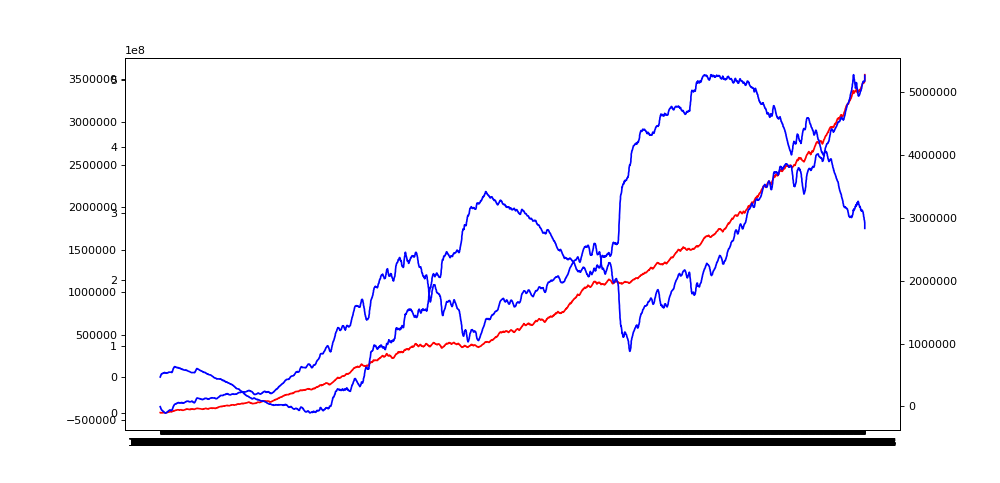

In [113]:
%nbagg

plot(results.trade_pnl.cumsum(), '-r')
gca().twinx().plot(results.option_pnl.cumsum(), '-b')
gca().twinx().plot(results.spx_pnl.cumsum(), '-g')










<IPython.core.display.Javascript object>


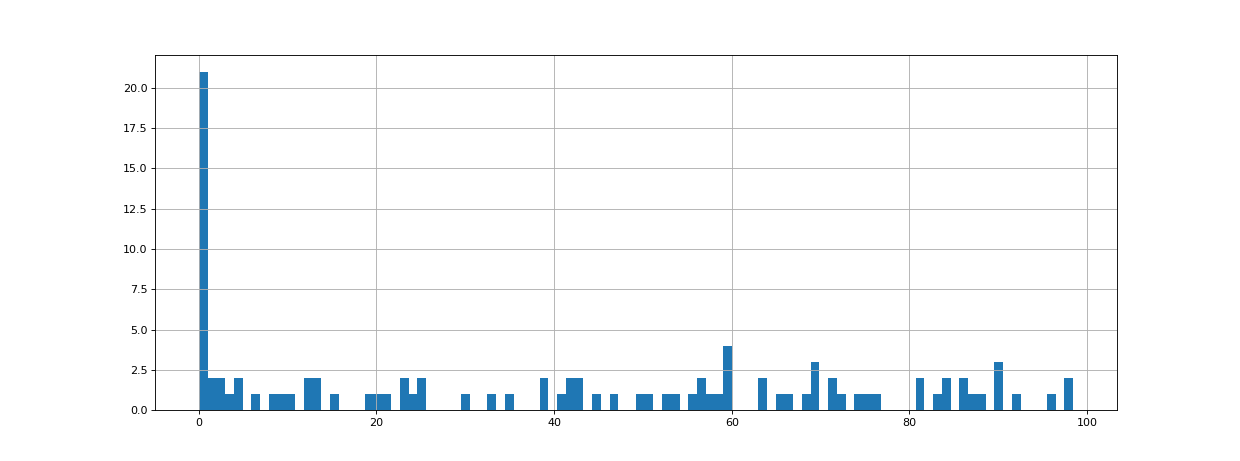

In [97]:
%nbagg

results.excess_capacity.hist(bins=100)




In [93]:
results.filter(regex='.*_rtn').corr()








,lagging_rtn,trade_rtn,option_rtn,total_rtn,spx_rtn
lagging_rtn,1.000000,0.581388,-0.105206,0.579259,0.180498
trade_rtn,0.581388,1.000000,0.045351,0.999878,0.593269
option_rtn,-0.105206,0.045351,1.000000,0.060952,0.203302
total_rtn,0.579259,0.999878,0.060952,1.000000,0.595956
spx_rtn,0.180498,0.593269,0.203302,0.595956,1.000000


In [82]:
%nbagg

results['17.total_rtn'].mean()/results['17.total_rtn'].std() * np.sqrt(252)


6.9473029978463243

<IPython.core.display.Javascript object>


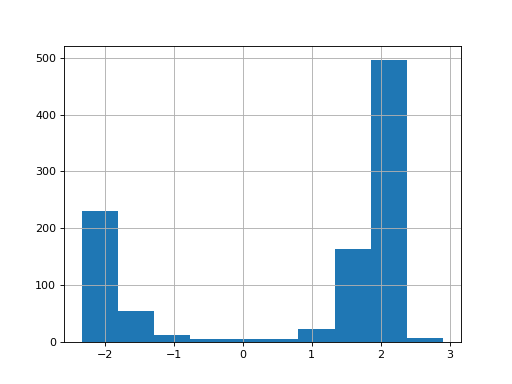

In [83]:
%nbagg

results['17.total_rtn'].hist()




             

In [49]:
%nbagg
pd.DataFrame(pnl).hist()





ValueError: If using all scalar values, you must pass an index

In [11]:
52211.420677 * 	326.459991


17044939.924310636

In [ ]:
option_cost


In [ ]:
data.rtn.std() * 30



In [ ]:
# try this with a finite horizon brownian motion for a straddle

%nbagg

def simulate( df, C = 1, fig=True):
    '''    
    C: capacity
    '''
    T = len(df)
    actions = []
    # share count
    sc = 0
    sca = []
    # my trading ledger
    b = 0
    ba = []
    # option account
    oa = []
    for t in range(T):
        a = 0
        # price fell - buy if we have capacity ...
        if df.dS[t] < 0 and  sc < C:                
            a = np.abs(df.dS[t]) 
        # ticked up  - sell if we have capacity
        elif df.dS[t] > 0 and sc > -C:            
            a = -np.abs(df.dS[t])             
        # total share count
        sc +=  a
        #add the trading  to my ledger
        b -= df.S[t] * a                
        actions.append(a)        
        sca.append(sc)
        ba.append(b)
        # the value of my straddle
        oa.append( C   * np.abs(df.S[t]  ) )
        
    df['action'] = actions
    df['trading_ledger']= ba
    df['num_shares'] = sca
    df['option_account'] = oa    
    df['total_pnl']  = df.option_account + df.trading_ledger    
    trading_sr = df.trading_ledger.diff().mean() / df.trading_ledger.diff().std() * sqrt(252)
    
    option_sr = df.option_account.diff().mean() / df.option_account.diff().std() * sqrt(252)
    total_sr = df.total_pnl.diff().mean() / df.total_pnl.diff().std() * sqrt(252)
        
    if fig:
        fig = figure(figsize=(15,5))
        subplot(1,3,1)
        plot( df['S'], '-k' )
        gca().set_ylabel('price', color='black',alpha=0.5)
        gca().set_title('price')
        ax = gca().twinx()
        ax.plot( df['num_shares'], '.r', alpha=0.5)
        ax.set_ylabel('num_shares',color='red')
        
        subplot(1,3,2)
        plot( df['trading_ledger'], '--r', alpha=0.5)
        plot( df['option_account'], '--g', alpha=0.5)
        ax = gca()
        ax.plot( df.total_pnl, '-k' )
        ax.set_ylabel('cumulative  pnl', color='black', alpha=0.5)
        ax.set_title('cumulative pnl')
        
        subplot(1,3,3)
        plot( df.trading_ledger.diff(), '-r', alpha=0.5)
        plot( df.option_account.diff(), '-g', alpha=0.5)
        plot( df.total_pnl.diff(), '--k', alpha=0.5)
        gca().set_title('daily pnl')
        gcf().suptitle('C={}, T={}'.format(C, T))
        print( 'trading SR', trading_sr, 'option sr', option_sr, 'total sr', total_sr)
        
    return df, trading_sr, option_sr, total_sr


# T = 100 
# sigma = 0.05
# pnl = []
# option = []
# trading = []
# trading_srs = []
# option_srs = [] 
# total_srs = []
# for k in tqdm.tqdm(range(1000)):
#     np.random.seed( k )    
#     #change from last tick
#     df = pd.DataFrame( dict( dS=sigma * randn(T) ))
#     df['S'] = df.dS.cumsum() # current price
#     df, trading_sr, option_sr, total_sr = simulate(df, C=C, fig=False)
#     pnl.append( df.iloc[-1]['total_pnl'])
#     option.append( df.iloc[-1]['option_account'])
#     trading.append( df.iloc[-1]['trading_ledger'])
#     trading_srs.append( trading_sr )
#     option_srs.append( option_sr )    
#     total_srs.append( total_sr )

In [ ]:
# one run simulation on the sp data
%nbagg

C = 10000
T = len(data)


df = data.copy()
df['dS'] = df.Close.diff()
df['S'] = df.dS.cumsum()
df['S'][0] = 0


df, trading_sr, option_sr, total_sr = simulate(df, C=C, fig=False  )


fig = figure(figsize=(15,5))
subplot(1,3,1)
plot( df['S'], '-k' )
gca().set_ylabel('price', color='black',alpha=0.5)

gca().set_title('price')
ax = gca().twinx()
ax.plot( df['num_shares'], '.r', alpha=0.5)
ax.set_ylabel('num_shares',color='red')

subplot(1,3,2)
plot( df['trading_ledger'], '--r', alpha=0.5)
# plot( df['option_account'], '--g', alpha=0.5)
ax = gca()
ax.plot( df.total_pnl, '-k' )
ax.set_ylabel('cumulative  pnl', color='black', alpha=0.5)

ax.set_title('cumulative pnl')

subplot(1,3,3)
plot( df.trading_ledger.diff(), '-r', alpha=0.5)
plot( df.option_account.diff(), '-g', alpha=0.5)
plot( df.total_pnl.diff(), '--k', alpha=0.5)
gca().set_title('daily pnl')
gcf().suptitle('C={}, T={}'.format(C, T))
print( 'trading SR', trading_sr, 'option sr', option_sr, 'total sr', total_sr)
df.trading_ledger.diff().corr(df.option_account.diff())




In [ ]:
%nbagg


plot( pnl, trading, '.r')
plot( pnl, option, '.b')

figure()
hist( trading_srs )







In [ ]:
# try this with a finite horizon brownian motion for a straddel option

%nbagg

T = 100
sigma = 0.05
C = 100

df = pd.DataFrame( dict(    
    dS=sigma * randn(T) #change from last tick
))
df['S'] = df.dS.cumsum() # current price

actions = []
# share count
sc = 0
sca = []
# my book / ledger
b = 0
ba = []
# option account
oa = []

for t in range(T):
    a = 0
    # price fell - buy
    if df.dS[t] < 0:
        # only if i'm already short
        if sc < 0:
            # buy ....
            a = 1
            sc += 1            
            b -=  df.S[t] #out side of the ledge
    # tick up ... short up to my call size
    elif df.dS[t] > 0:
        if -sc < C:
            a = -1
            sc -= 1
            b += df.S[t]  #in  side of the ledge
    actions.append(a)        
    sca.append(sc)
    ba.append(b)
    # the value of my option
    oa.append( C * df.S[t] if df.S[t] > 0 else 0 )
    
    

df['action'] = actions
df['book']= ba
df['num_shares'] = sca
df['option_account'] = oa

subplot(2,2,1)
plot( df['S'], '-k' )
gca().set_title('price')
ax = gca().twinx()
ax.plot( df['num_shares'], '.r')

subplot(2,2,2)
plot( df['option_account'] )
gca().set_title('option_value')
ax = gca().twinx()
ax.plot( df['num_shares'], '.r')

subplot(2,2,3)
plot( df['book'].cumsum() )
gca().set_title('book')
ax = gca().twinx()
ax.plot( df['num_shares'], '.r')


subplot(2,2,4)

plot( df['book'].cumsum() + df.option_account, '-k' )
gca().set_title('total pnl')
ax = gca().twinx()

ax.plot( df['num_shares'], '.r')






In [ ]:
%matplotlib nbagg

N = 1000
p1 = 10
p2 = 5

# tf.reset_default_graph()
# del sess
# sess = tf.InteractiveSession()
# g = tf.Graph().as_default()
# W1 = tf.Variable( randn(p1, p2 ) )
# W2 = tf.Variable( randn( p2, 1) )
# X = randn( N, p1 )
# h1 = tf.nn.relu( tf.matmul(X,  W1 ), name='h1' )
# y = tf.tanh ( tf.matmul(h1, W2), name='y') + randn(N,1)
# sess.run(tf.initialize_all_variables())
# y.eval()



def relu( x ):
    return x * (x > 0)

def I(x):
    return x

# build the true dataset
W1 = randn(p1, p2 )
W2 = randn( p2, 1) 

Z_trg = randn( N, p1 )
y_trg = I ( exp( Z_trg @ W1 ) @ W2 ) + randn(N,1)
Z_tst = randn( N, p1 )
y_tst = I ( exp( Z_tst @ W1 ) @ W2 ) + randn(N,1)

def evaluate(yhat_trg, yhat_tst):
    return norm( yhat_trg - y_trg ) ** 2 / norm(y_trg)**2,  norm( yhat_tst - y_tst ) ** 2 / norm(y_tst)**2


# build a larger (polynomial) feature space

def make_features(Z, po):
    return hstack( [ Z, Z**2, Z**3, Z**4, Z**5, Z**2/2+Z**3/6, Z@ W1, (Z@ W1)**2, randn(N, p1*p2*po) ] )
#     return hstack( [array( [ np.cos(Z[:,i]*p) for i in range(Z.shape[1]) for p in range(1, p1) ] ).T, 
#                     randn(N, p1)] )

X_trg = make_features(Z_trg, 3)
X_tst = make_features(Z_tst, 3)

# test simple ridge regression
from sklearn import linear_model

ridge = {}
alphas = linspace(3, 10, 100)
for alpha in alphas:
    print(dt.datetime.now(), alpha)
    reg = linear_model.Ridge (alpha = 10**alpha, fit_intercept=True)
    reg.fit( X_trg, y_trg )
    yhat_trg = reg.predict(X_trg);
    mse_trg, mse_tst = evaluate( yhat_trg, reg.predict(X_tst) )    
    beta_norm = norm( reg.coef_ )
    evs = linalg.eigvals( X_trg.T @ X_trg )
    df = np.sum( evs / (evs + alpha) )
    log_rss = log( norm( yhat_trg - y_trg ) ** 2  );
    aic =  X_trg.shape[0] * log_rss + 2 * df;
    bic =  X_trg.shape[0] * log_rss + df * log( X_trg.shape[0] );
    # do GCV
    reg_gcv = linear_model.RidgeCV( alphas=(alpha,), fit_intercept=True )
    reg_gcv.fit(X_trg, y_trg)
    mse_gcv_trg, mse_gcv_tst = evaluate( reg_gcv.predict(X_trg), reg_gcv.predict(X_tst) )    
    ridge[alpha] = ( mse_trg, mse_tst, aic, bic, mse_gcv_trg, mse_gcv_tst, beta_norm)

a, values = list(zip(*ridge.items()))
mse_trg, mse_tst, aic, bic,  mse_gcv_trg, mse_gcv_tst, beta_norm = list(zip(*values))
mse_gcv_trg = [ _ if isfinite( _ ) else 0 for _ in mse_gcv_trg ]
mse_gcv_tst = [ _ if isfinite( _ ) else 0 for _ in mse_gcv_tst ]

subplot(221);
plot( a, mse_trg, '.k', label='trg error')
gca().tick_params(axis='y', colors='black')
ax = gca().twinx()
ax.plot( a, mse_tst, '.r', label='tst error')
ax.tick_params(axis='y', colors='red')
#ax.set_ylim( (min(mse_trg+mse_tst)-0.1, max(mse_trg+mse_tst)+0.1) )
gca().set_title('Ridge trg_mse and tst_mse')

subplot(222);
gca().plot( a, aic, '.k', label='AIC')
gca().set_xlim((-1, alphas[-1]+1))
gca().set_ylabel('AIC')
ax = gca().twinx();
ax.plot( a, bic, '.r', label='BIC')
ax.set_ylabel('BIC')
ax.tick_params(axis='y', colors='red')
gca().set_title('AIC vs BIC ')


subplot(223);
plot( a, mse_gcv_trg, '.k', label='GCV trg error')
ax = gca().twinx();
ax.plot( a, mse_gcv_tst, '.r', label='GCV tst error')
ax.tick_params(axis='y', colors='red')
# gca().set_ylim( (min(mse_gcv_trg+mse_gcv_tst)-0.1, max(mse_gcv_trg+mse_gcv_tst)+0.1) )
gca().set_title('GCV trg_mse and tst_mse')


subplot(224);
plot( a, beta_norm, '.k', label='norm of beta')
gca().set_ylim( (min(beta_norm)-0.1, max(beta_norm)+0.1) )
gca().set_title('orm of beta')


# build a set of features

# yhat = 




In [ ]:
# imports
from pandas import *
from pylab import *
import sys, os, re, importlib
print( 'running', sys.executable)
from importlib import reload
import tensorflow as tf
import tflearn as tfl
import numpy as np
import datetime as dt


In [ ]:
reg.coef_

In [ ]:
from sklearn import linear_model
reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0])
reg.fit([[0, 0], [0, 0], [1, 1]], [0, .1, 1])       
RidgeCV(alphas=[0.1, 1.0, 10.0], cv=None, fit_intercept=True, scoring=None,
    normalize=False)
reg.alpha_                                      
0.1